# 最大似然
:label:`sec_maximum_likelihood`

在机器学习中，最常遇到的思维方式之一是最大似然的观点。这意味着当我们处理一个具有未知参数的概率模型时，使数据具有最高概率的参数是最有可能的参数。

## 最大似然原理

这有一个贝叶斯解释，有助于我们思考。假设我们有一个参数为$\boldsymbol{\theta}$的模型和一组数据示例$X$。具体来说，我们可以想象$\boldsymbol{\theta}$是一个表示硬币抛掷时正面朝上的概率的单一值，而$X$是一系列独立的硬币抛掷结果。稍后我们将深入研究这个例子。

如果我们想要找到模型参数的最可能值，那就意味着我们想要找到

$$\mathop{\mathrm{argmax}} P(\boldsymbol{\theta}\mid X).$$
:eqlabel:`eq_max_like`

根据贝叶斯规则，这与

$$
\mathop{\mathrm{argmax}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}.
$$

相同。

表达式$P(X)$，即生成数据的与参数无关的概率，根本不依赖于$\boldsymbol{\theta}$，因此可以去掉而不改变最佳选择$\boldsymbol{\theta}$。同样地，我们现在可以假定我们对哪组参数优于其他参数没有任何先验假设，因此我们可以声明$P(\boldsymbol{\theta})$也不依赖于$\theta$！例如，在我们的硬币抛掷例子中，正面朝上的概率可以是$[0,1]$中的任何值，而无需事先认为它是公平的还是不公平的（通常称为*无信息先验*）。因此我们看到，应用贝叶斯规则表明我们最好的$\boldsymbol{\theta}$选择是$\boldsymbol{\theta}$的最大似然估计：

$$
\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta}).
$$

按照通用术语，给定参数的数据概率（$P(X \mid \boldsymbol{\theta})$）被称为*似然*。

### 一个具体的例子

让我们看看在一个具体例子中这是如何工作的。假设我们有一个单独的参数$\theta$代表硬币抛掷出现正面的概率。那么出现反面的概率就是$1-\theta$，所以如果我们的观测数据$X$是一个包含$n_H$个正面和$n_T$个反面的序列，我们可以利用独立概率相乘的事实来看到

$$
P(X \mid \theta) = \theta^{n_H}(1-\theta)^{n_T}.
$$

如果我们抛掷13次硬币并得到序列"HHHTHTTHHHHHT"，其中$n_H = 9$和$n_T = 4$，我们看到这是

$$
P(X \mid \theta) = \theta^9(1-\theta)^4.
$$

在这个例子中一个好的地方是我们事先就知道答案。确实，如果我们口头说，“我抛了13次硬币，有9次正面朝上，我们对硬币出现正面概率的最佳猜测是什么？”，每个人都会正确地猜出$9/13$。这种最大似然方法将给我们一种从第一原则出发来得到这个数字的方法，这种方法可以推广到极其复杂的情况。

对于我们的例子，$P(X \mid \theta)$的图如下：

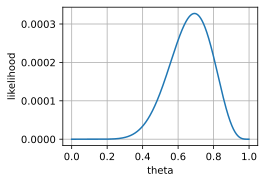

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

theta = torch.arange(0, 1, 0.001)
p = theta**9 * (1 - theta)**4.

d2l.plot(theta, p, 'theta', 'likelihood')

这在接近我们预期的 $9/13 \approx 0.7\ldots$ 的某个地方达到最大值。要看看它是否正好在那里，我们可以转向微积分。请注意，在最大值处，函数的梯度是平的。因此，我们可以通过找到导数为零的 $\theta$ 值，并找到给出最高概率的那个值来找到最大似然估计 :eqref:`eq_max_like`。我们计算：

$$
\begin{aligned}
0 & = \frac{d}{d\theta} P(X \mid \theta) \\
& = \frac{d}{d\theta} \theta^9(1-\theta)^4 \\
& = 9\theta^8(1-\theta)^4 - 4\theta^9(1-\theta)^3 \\
& = \theta^8(1-\theta)^3(9-13\theta).
\end{aligned}
$$

这有三个解：$0$、$1$ 和 $9/13$。前两个显然是最小值，而不是最大值，因为它们给我们的序列分配了 $0$ 概率。最后一个值*不*给我们的序列分配零概率，因此必须是最大似然估计 $\hat \theta = 9/13$。

## 数值优化和负对数似然

前面的例子很好，但如果我们有数十亿个参数和数据样本怎么办？

首先，请注意，如果我们假设所有数据样本都是独立的，我们就不再能够实际考虑似然本身，因为它是由许多概率相乘得到的。实际上，每个概率都在 $[0,1]$ 范围内，通常约为 $1/2$，而 $(1/2)^{1000000000}$ 的乘积远远低于机器精度。我们不能直接使用那个数值。

然而，请记住，对数可以将乘积转换为求和，这样一来

$$
\log((1/2)^{1000000000}) = 1000000000\cdot\log(1/2) \approx -301029995.6\ldots
$$

这个数字完全适合甚至单精度 $32$ 位浮点数。因此，我们应该考虑*对数似然*，它是

$$
\log(P(X \mid \boldsymbol{\theta})).
$$

由于函数 $x \mapsto \log(x)$ 是递增的，最大化似然与最大化对数似然是相同的。确实，在 :numref:`sec_naive_bayes` 中，当我们处理朴素贝叶斯分类器的具体示例时，我们将看到这种推理的应用。

我们经常处理损失函数，其中我们希望最小化损失。我们可以通过取 $-\log(P(X \mid \boldsymbol{\theta}))$ 将最大似然转化为最小化损失，这就是*负对数似然*。

为了说明这一点，考虑之前的硬币翻转问题，并假装我们不知道闭式解。我们可以计算出

$$
-\log(P(X \mid \boldsymbol{\theta})) = -\log(\theta^{n_H}(1-\theta)^{n_T}) = -(n_H\log(\theta) + n_T\log(1-\theta)).
$$

这可以写成代码，即使对于数十亿次硬币翻转也可以自由优化。

In [2]:
# Set up our data
n_H = 8675309
n_T = 256245

# Initialize our paramteres
theta = torch.tensor(0.5, requires_grad=True)

# Perform gradient descent
lr = 1e-9
for iter in range(100):
    loss = -(n_H * torch.log(theta) + n_T * torch.log(1 - theta))
    loss.backward()
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.grad.zero_()

# Check output
theta, n_H / (n_H + n_T)

(tensor(0.9713, requires_grad=True), 0.9713101437890875)

数值便利性并不是人们喜欢使用负对数似然的唯一原因。还有其他几个原因使其更受欢迎。

我们考虑对数似然的第二个原因是简化了微积分规则的应用。如上所述，由于独立性假设，我们在机器学习中遇到的大多数概率都是单个概率的乘积。

$$
P(X\mid\boldsymbol{\theta}) = p(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta})\cdots p(x_n\mid\boldsymbol{\theta}).
$$

这意味着如果我们直接应用乘法法则来计算导数，我们会得到

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} P(X\mid\boldsymbol{\theta}) & = \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right)\cdot P(x_2\mid\boldsymbol{\theta})\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_2\mid\boldsymbol{\theta})\right)\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \vdots \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot P(x_2\mid\boldsymbol{\theta}) \cdots \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right).
\end{aligned}
$$

这需要$n(n-1)$次乘法运算，以及$(n-1)$次加法运算，因此它与输入成二次关系！通过巧妙地组合项可以将其减少到线性时间，但这需要一些思考。对于负对数似然，我们有

$$
-\log\left(P(X\mid\boldsymbol{\theta})\right) = -\log(P(x_1\mid\boldsymbol{\theta})) - \log(P(x_2\mid\boldsymbol{\theta})) \cdots - \log(P(x_n\mid\boldsymbol{\theta})),
$$

从而给出

$$
- \frac{\partial}{\partial \boldsymbol{\theta}} \log\left(P(X\mid\boldsymbol{\theta})\right) = \frac{1}{P(x_1\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right) + \cdots + \frac{1}{P(x_n\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right).
$$

这只需要$n$次除法和$n-1$次求和，因此它是线性时间。

考虑负对数似然的第三个也是最后一个原因是其与信息理论的关系，我们将在:numref:`sec_information_theory`中详细讨论。这是一个严格的数学理论，提供了一种衡量随机变量中的信息量或随机性的方法。该领域研究的关键对象是熵，定义为

$$
H(p) = -\sum_{i} p_i \log_2(p_i),
$$

它测量源的随机性。请注意，这只是平均$-\log$概率，因此如果我们将我们的负对数似然除以数据样本数量，我们就得到了一个称为交叉熵的熵的变体。仅此理论解释就足以促使将数据集上的平均负对数似然作为衡量模型性能的一种方式。

## 连续变量的最大似然

到目前为止我们所做的一切都假设我们正在处理离散随机变量，但如果我们想处理连续变量呢？

简短的总结是，除了将所有概率实例替换为概率密度外，没有任何变化。回想一下，我们用小写字母$p$表示密度，这意味着例如我们现在说

$$
-\log\left(p(X\mid\boldsymbol{\theta})\right) = -\log(p(x_1\mid\boldsymbol{\theta})) - \log(p(x_2\mid\boldsymbol{\theta})) \cdots - \log(p(x_n\mid\boldsymbol{\theta})) = -\sum_i \log(p(x_i \mid \theta)).
$$

问题是，“为什么这样做是可以的？”毕竟，我们引入密度的原因是因为获得特定结果的概率本身为零，那么对于任何一组参数生成数据的概率不是也为零吗？

确实如此，理解为什么我们可以转向密度是对epsilon的变化进行追踪的一个练习。

让我们首先重新定义我们的目标。假设对于连续随机变量，我们不再想要计算得到完全正确的值的概率，而是希望在某个范围$\epsilon$内匹配。为了简单起见，我们假设我们的数据是重复观察$x_1, \ldots, x_N$来自同分布的随机变量$X_1, \ldots, X_N$。正如我们之前看到的，这可以写成

$$
\begin{aligned}
&P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\mid\boldsymbol{\theta}) \\
\approx &\epsilon^Np(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta}) \cdots p(x_n\mid\boldsymbol{\theta}).
\end{aligned}
$$

因此，如果我们取这个表达式的负对数，我们得到

$$
\begin{aligned}
&-\log(P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\mid\boldsymbol{\theta})) \\
\approx & -N\log(\epsilon) - \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})).
\end{aligned}
$$

如果我们检查这个表达式，$\epsilon$只出现在加性常数$-N\log(\epsilon)$中。这根本不依赖于参数$\boldsymbol{\theta}$，所以$\boldsymbol{\theta}$的最佳选择并不取决于我们对$\epsilon$的选择！如果我们要求四位数或四百位数，$\boldsymbol{\theta}$的最佳选择保持不变，因此我们可以自由地去掉$\epsilon$来看到我们想要优化的是

$$
- \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})).
$$

因此，我们看到最大似然的观点可以像处理离散变量一样容易地处理连续变量，只需将概率替换为概率密度。

## 摘要
* 最大似然原则告诉我们，给定数据集的最佳拟合模型是生成数据概率最高的模型。
* 通常人们出于各种原因（数值稳定性、将乘积转换为和（以及由此带来的梯度计算简化）和与信息理论的理论联系）而使用负对数似然。
* 虽然在离散设置中最易于激励，但也可以通过最大化分配给数据点的概率密度而自由地推广到连续设置。

## 练习
1. 假设你知道一个非负随机变量具有密度$\alpha e^{-\alpha x}$，其中$\alpha>0$。你从随机变量中获得了单个观测值3。$\alpha$的最大似然估计是什么？
2. 假设你有一个样本集$\{x_i\}_{i=1}^N$，这些样本是从均值未知但方差为1的高斯分布中抽取的。均值的最大似然估计是什么？

[讨论](https://discuss.d2l.ai/t/1096)